**Тестовое задание для поступления на кафедру Системного программирования**

Задание состоит из нескольких этапов:
1.   Реализация свёрточной нейронной сети на основе библиотеки PyTorch, используя датасет Cifar-10;
2.   Реализация оптимизатора Adam на основе статьи "ADAM: A METHOD FOR STOCHASTIC OPTIMIZATION";
3.   Обучение нейронной сети, используя написанный оптимизатор Adam;
4.   Проведение обучения, используя оптимизатор SGD из библиотеки PyTorch;
5.   Анализ полученных результатов обучений и представление результатов на графиках, используя библиотеку Matplotlib.


Для начала подключаем необходимые библиотеки и импортируем необходимые функции из них для удобства:

In [12]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
from torch import nn
from torch.optim import Optimizer
import matplotlib.pyplot as plt
#from adam import Adam

Теперь реализуем 2 важнейшие функции: обучение и тестирование модели. Здесь использовался стандартный алгоритм обучения: обнуление градиентов, подсчёт результата работы нейронной сети на входных данных, подсчёт функции потерь и проведение шага оптимизатора:

In [2]:
#функция-обучения нейронной сети
def train_loop(data, model, func_loss, optimizer):
    size = len(data.dataset)

    model.train()
    running_loss = 0.0
    for batch, (inputs, labels) in enumerate(data, 0):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = func_loss(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if (batch + 1) % 2500 == 0:
            print(f"loss: {running_loss / 2000:>7f}  [{(batch + 1) * batch_size:>5d}/{size:>5d}]")
            running_loss = 0.0


Теперь реализуем функцию проверки точности нейронной сети на тестовых данных:

In [19]:
#функция-тестирование нейронной сети
def test_loop(data, model, func_loss):
    correct = 0
    total = 0
    test_loss = 0

    model.eval()
    with torch.no_grad():
        for (inputs, labels) in data:
            outputs = model(inputs)
            test_loss += func_loss(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%, loss: %.7f' % (100 * correct / total, test_loss / (total / batch_size)))
    return (100 * correct / total), (test_loss / (total / batch_size))

Укажем наши гиперпараметры, которые удобно менять для увеличения точности нейронной сети:

In [4]:
#выбор гиперпараметров
batch_size = 4
learn_rate = 1e-3
epoch = 2
momentum = 0.9

Теперь проведем загрузку датасета с помощью функций библиотеки torchvision. После разобъём наши датасеты по партиям:

In [5]:
#Преобразование данных: перевод в тензор из PyTorch и нормализация
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#загрузка датасета
data_train = datasets.CIFAR10(root = "./data", train = True, download = True, transform = transform)
data_test = datasets.CIFAR10(root = "./data", train = False, download = False, transform = transform)
#разбитие данных на партии
dataload_train = DataLoader(data_train, batch_size = batch_size, shuffle = True)
dataload_test = DataLoader(data_test, batch_size = batch_size, shuffle = True)

100%|██████████| 170M/170M [00:04<00:00, 41.5MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


Настало время написать класс устройства нашей нейронной сети. Здесь мы инициализируем нейронную сеть, состоящую из 5 важных слоёв: 2 свёрточных и 3 линейных слоя:

In [6]:
#представление модели нейронной сети
class NeuralNetworks(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 6, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(16 * 5 * 5, 120,),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10)
        )

    def forward(self, input):
        output = self.network(input)
        return output

Здесь приведена реализация алгоритма из статьи "ADAM: A METHOD FOR STOCHASTIC OPTIMIZATION". Для удобства, реализация в виде класса, для более удобной инициализации переменных, а также класс наследуется от библиотечного torch.optim.Optimizer, чтобы использовать библиотечную реализацию функции zero_grad():

In [7]:
class Adam(Optimizer):
    def __init__(self, param, alpha = 1e-3, beta1 = 0.9, beta2 = 0.999, eps = 1e-8):
        self.param = list(param)
        number_of_param = sum([par.numel() for par in self.param])
        self.t = 0
        self.m = [0] * number_of_param
        self.v = [0] * number_of_param
        defaults = dict(lr=alpha, betas=(beta1, beta2), eps=eps)
        super().__init__(self.param, defaults)
        # self.alpha = alpha
        # self.beta1 = beta1
        # self.beta2 = beta2
        # self.eps = eps

    def step(self):
        self.t += 1
        i = 0
        for group in self.param_groups:
          alpha, eps = group['lr'], group['eps']
          beta1, beta2 = group['betas']
          for par in group['params']:
            gt = par.grad.data
            self.m[i] = beta1 * self.m[i] + (1 - beta1) * gt
            self.v[i] = beta2 * self.v[i] + (1 - beta2) * (gt ** 2)
            mt = self.m[i] / (1 - beta1 ** self.t)
            vt = self.v[i] / (1 - beta2 ** self.t)
            par.data = par.data - alpha * mt / (vt ** 0.5 + eps)
            i += 1

Теперь мы готовы объявить нашу нейронную сеть, а также функции потерь CrossEntropyLoss и наш оптимизатор (здесь закомментирована инициализация оптимизатора SGD):

In [8]:
#инициализация модели свёрточной нейронной сети, выбор функции потерь и оптимизитора
model = NeuralNetworks()
loss_func = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.parameters(), lr = learn_rate, momentum = momentum)
optimizer = Adam(model.parameters(), alpha = learn_rate)

Также создадим массивы для хранения данных тестирования для дальнейшей визуализации:

In [18]:
x = range(1, epoch + 1)
loss_mas = [0] * epoch
accuracy_mas = [0] * epoch

Далее запускаем цикл обучения, которая вызывает соответственно функции обучения модели и проверки результатов работы на тестовом датасете:

In [20]:
#цикл обучения и проверки результатов обучения нейронной сети
for ep in range(epoch):
    print(f"Epoch {ep + 1}\n-------------------------------")
    train_loop(dataload_train, model, loss_func, optimizer)
    accuracy_mas[ep], loss_mas[ep] = test_loop(dataload_test, model, loss_func)

Epoch 1
-------------------------------
loss: 1.253221  [10000/50000]
loss: 1.293477  [20000/50000]
loss: 1.313807  [30000/50000]
loss: 1.321105  [40000/50000]
loss: 1.314826  [50000/50000]
Accuracy of the network on the 10000 test images: 59 %, loss: 1.1943359
Epoch 2
-------------------------------
loss: 1.233480  [10000/50000]
loss: 1.257587  [20000/50000]
loss: 1.258815  [30000/50000]
loss: 1.266907  [40000/50000]
loss: 1.285371  [50000/50000]
Accuracy of the network on the 10000 test images: 60 %, loss: 1.1251145


Теперь мы можем визуализировать на графиках работу модели:

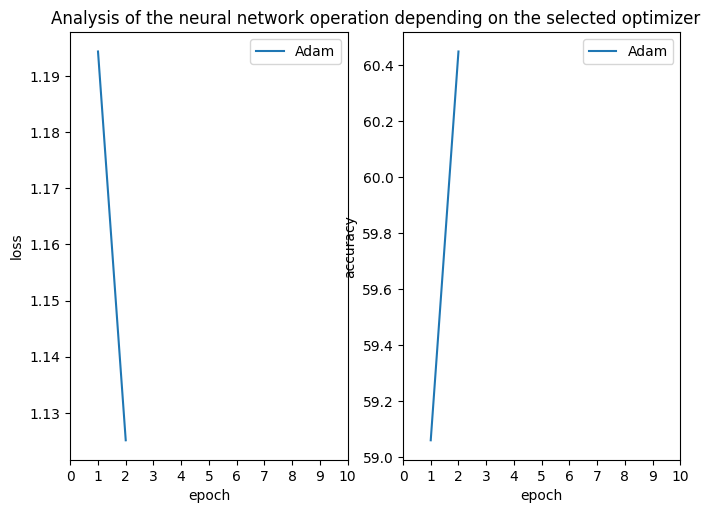

In [31]:
plt.title('Analysis of the neural network operation depending on the selected optimizer')
plt.axis('off')
plt.tight_layout()
plt.subplot(1, 2, 1)
plt.plot(x, loss_mas, label = "Adam")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.xticks(range(0, 11))
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(x, accuracy_mas, label = "Adam")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.xticks(range(0, 11))
plt.legend()
plt.show()

После обучения модели, можем сохранить её для дальнейшей работы с ней:

In [32]:
#сохранение модели
torch.save(model, 'model.pth')